# Alpha lifetime

An script to compute alpha lifetime.

In [1]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
from glob import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
from invisible_cities.core.system_of_units_c import units
#import invisible_cities.core.system_of_units_c as units
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams


sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2


from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2,\
                               time_from_timestamp, lifetime

pi = np.pi



Running on  Fri May  5 19:28:34 2017


In [2]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-05-05 19:28:37


In [3]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [4]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### Run Parameters

In [64]:
runs = [3645,
        3715,
        3724,
        3733,
        3741,
        3753,
        3756,
        3758,
        3762,
        3767,
        3769,
        3772,
        3774,
        3782,
        3784,
        3788,
        3790,
        3793,
        3795,
        3822,
        3824,
        3826,
        3829,
#run 3855
        3883,
        3888]



using data set with length 18191
t0 = 2017-04-14 22:40:35 (index = 0) t1 = 2017-04-18 06:38:20 (index = 18191)
bin length = 6063
 ---fit over events between 0 and 6062
time0 = 2017-04-14 22:40:35 time1 = 2017-04-15 22:55:10
size of time leg = 6062
fit par[0] = 60500.659054776166 error = 339.09935413399046
fit par[1] = -430.5311742915762 error = 4.436734201423593
degrees of freedom = 2
chi2 = 2.597594014659839
 ---fit over events between 6063 and 12125
time0 = 2017-04-15 22:55:11 time1 = 2017-04-17 01:53:07
size of time leg = 6062
fit par[0] = 59823.042247118814 error = 401.34269082780264
fit par[1] = -463.13351349188076 error = 6.144693231783019
degrees of freedom = 2
chi2 = 3.2679038167770913
 ---fit over events between 12126 and 18188
time0 = 2017-04-17 01:56:46 time1 = 2017-04-18 06:38:20
size of time leg = 6062
fit par[0] = 61338.861427703916 error = 29.97816434560942
fit par[1] = -474.4109931194628 error = 0.4561052112975439
degrees of freedom = 2
chi2 = 0.23965047760469543
using 

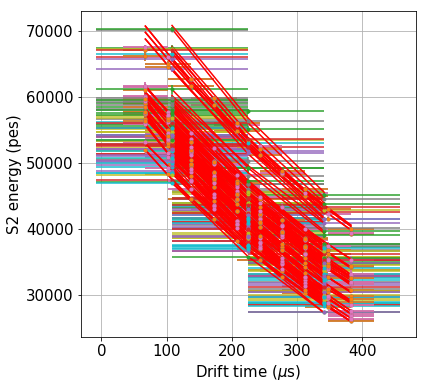

In [70]:
LT  = {}
times = []
times_all = []
lifetimes_all = []
elambdas_all = []
lifetimes = []
elambdas = []
s1es = []
s2es = []
zs = []

for run_number in runs:
    
    DataPMT = load_db.DataPMT(run_number)
    DataSiPM = load_db.DataSiPM(run_number)
    xs = DataSiPM.X.values
    ys = DataSiPM.Y.values
    
    ifile = os.path.join(os.environ['IC_DATA'], 'LSC/kdst/dst_{}.root.h5'.format(run_number)) 
    full = load_dst(ifile)
    full.head()
    
    r = event_rate(full)
    st = datetime.datetime.fromtimestamp(full.time[-1:]).strftime('%Y-%m-%d %H:%M:%S')
    core = full[full.R < 100]     # Cuts
    zrange =   50, 400
    Erange = 1e+3, 70e3
    nbins = 10
    F, x, y, sy = profile_and_fit(core.Z, core.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))
    
    cz = core[in_range(core.Z ,50, 400)]
    
    s1es.append(cz.S1e.mean())
    s2es.append(cz.S2e.mean())
    zs  .append(cz.Z  .mean())
    
    zrange =   50, 400
    Erange = 1e+3, 70e3
    nbins = 10
    F, x, y, sy = profile_and_fit(cz.Z, cz.S2e, 
                        xrange=zrange, 
                        yrange=Erange, 
                        nbins=nbins, 
                        fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))
    st0 = time_from_timestamp(full.time[0])
    st1 = time_from_timestamp(full.time[-1:])
    CHI2, LAMBDA, ELAMBDA, TSTAMP, TIME = lifetime(dst=cz, zrange=(50,400), Erange=(1e+3, 80e3), nbins=3)

    times.append(TIME[np.argmin(ELAMBDA)])
    lifetimes.append(-np.array(LAMBDA)[np.argmin(ELAMBDA)])
    elambdas .append( np.min (ELAMBDA))
    LT[run_number] = -np.array(LAMBDA)[np.argmin(ELAMBDA)]
    
    times_all.extend(TIME)
    lifetimes_all.extend(-np.array(LAMBDA))
    elambdas_all.extend(ELAMBDA)

    



    

In [71]:
times = np.array(times)
times_all = np.array(times_all)
lifetimes_all = np.array(lifetimes_all)
elambdas_all = np.array(elambdas_all)
lifetimes = np.array(lifetimes)
elambdas = np.array(elambdas)
s1es = np.array(s1es)
s2es = np.array(s2es)
zs = np.array(zs)

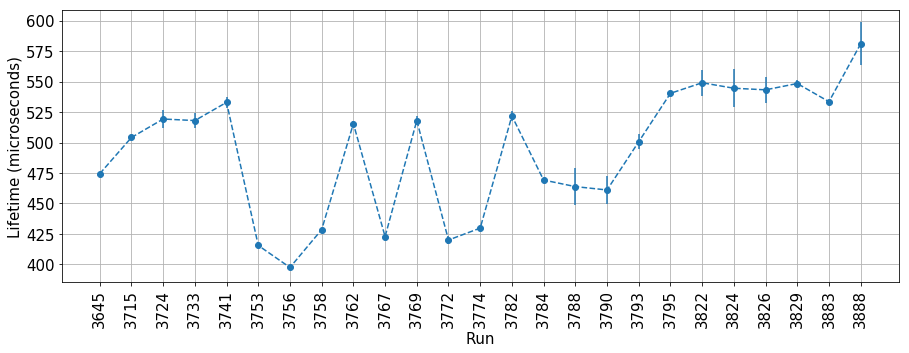

In [72]:
plt.figure(figsize=(15,5))
#plt.plot(times, lifetimes)
plt.errorbar(range(len(lifetimes)), lifetimes, yerr=elambdas, linestyle='--', fmt='o')
plt.xticks(range(len(lifetimes)), runs, rotation='vertical')
plt.grid(True)
plt.xlabel('Run')
plt.ylabel('Lifetime (microseconds)')
plt.show()


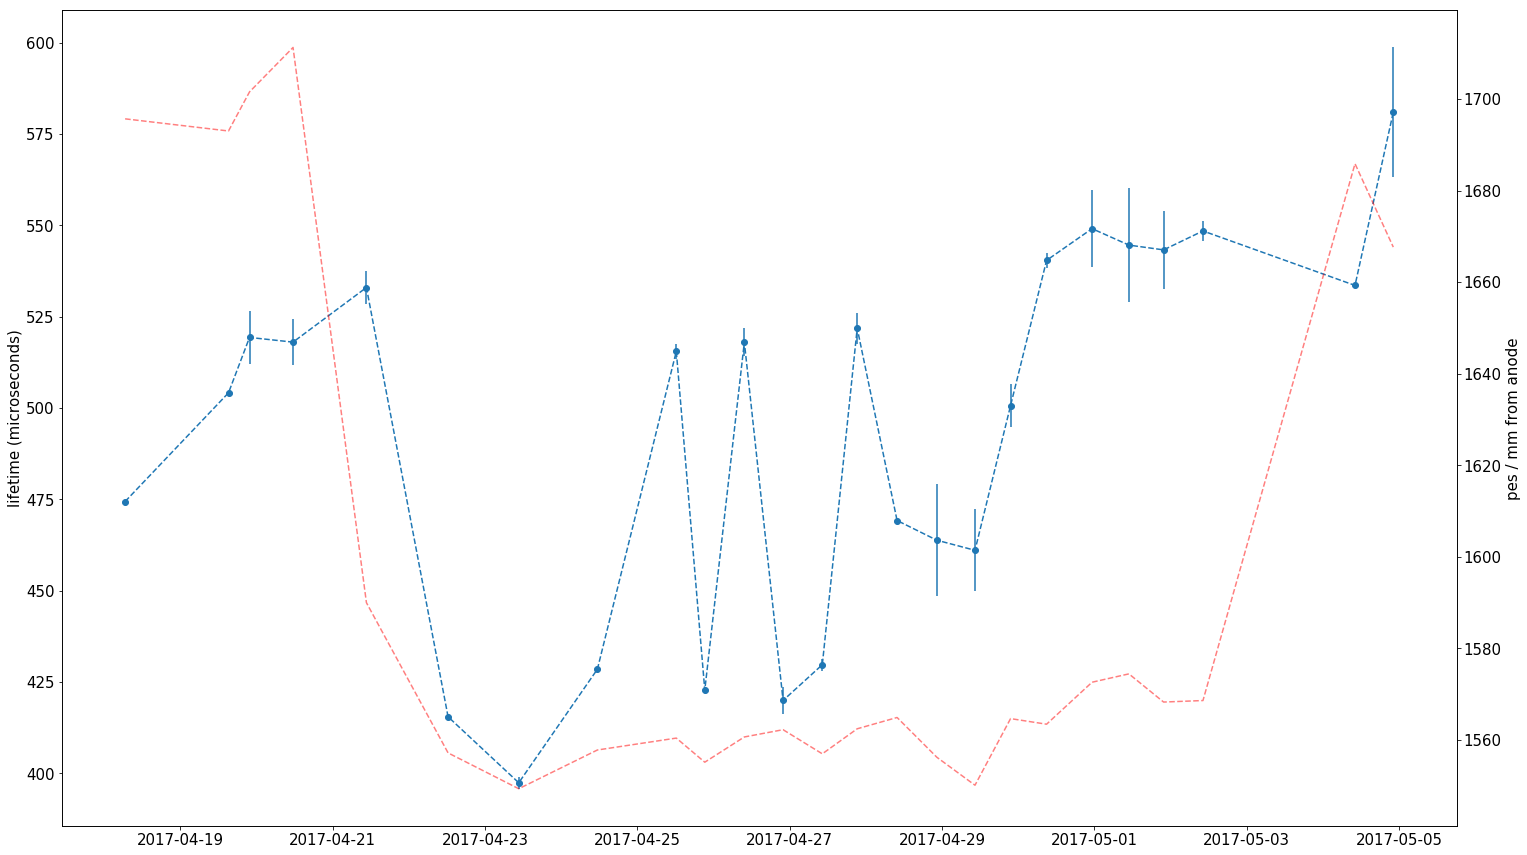

In [91]:
fig, ax1 = plt.subplots(figsize=(25,15))
ax1.errorbar(times, lifetimes, yerr=elambdas, linestyle='--', fmt='o')
ax1.set_ylabel('lifetime (microseconds)')
ax2 = ax1.twinx()
ax2.plot(times, s1es, c='red', alpha=.5, linestyle='--')
ax2.set_ylabel('pes / mm from anode')
plt.show()

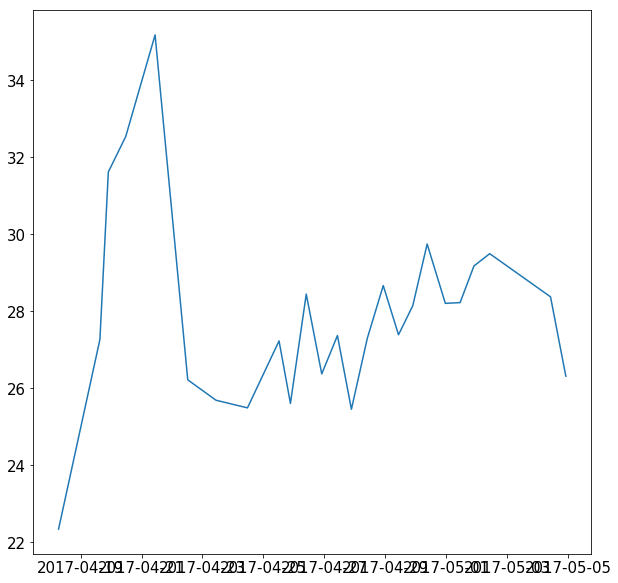

In [101]:
plt.figure(figsize=(10,10))
plt.plot(times, s2es / s1es)

In [99]:
s2es /s1es

array([ 22.33763239,  27.26613295,  31.61525792,  32.536806  ,
        35.17690942,  26.21556147,  25.68526437,  25.48722129,
        27.22604465,  25.60287292,  28.44252934,  26.36893083,
        27.36616446,  25.45039138,  27.29870408,  28.66411341,
        27.38619597,  28.13942116,  29.74313947,  28.20248014,
        28.22177249,  29.17365859,  29.49318241,  28.37163059,  26.30998827])

In [68]:
plog = os.path.join(os.environ['IC_DATA'], 'LSC/logs/pressure/Plot_Log/')

pfiles = [
          plog + 'GAS_Log_2017-04-15.txt',
          plog + 'GAS_Log_2017-04-16.txt',
          plog + 'GAS_Log_2017-04-17.txt',
          plog + 'GAS_Log_2017-04-18.txt',
          plog + 'GAS_Log_2017-04-19.txt',
          plog + 'GAS_Log_2017-04-20.txt',
          plog + 'GAS_Log_2017-04-21.txt',
          plog + 'GAS_Log_2017-04-22.txt',
          plog + 'GAS_Log_2017-04-23.txt',
          plog + 'GAS_Log_2017-04-24.txt',
          plog + 'GAS_Log_2017-04-25.txt',
          plog + 'GAS_Log_2017-04-26.txt',
          plog + 'GAS_Log_2017-04-27.txt',
          plog + 'GAS_Log_2017-04-28.txt',
          plog + 'GAS_Log_2017-04-29.txt',
          plog + 'GAS_Log_2017-04-30.txt',
          plog + 'GAS_Log_2017-05-01.txt',
          plog + 'GAS_Log_2017-05-02.txt',
          plog + 'GAS_Log_2017-05-03.txt',
          plog + 'GAS_Log_2017-05-04.txt',
          plog + 'GAS_Log_2017-05-05.txt']
f0 = pd.read_csv(pfiles[0], skiprows=2, sep=None, engine='python', decimal=",")

T  =[]
pg3=[]
pg6=[]
for f in pfiles: 
    f = pd.read_csv(f, skiprows=2, sep=None, engine='python')

    for d, t, g3, g6 in zip(f['Date'].values, f['Hour'].values, f['PG3'].values, f['PG6'].values):
        if len(t)==7: t = '0' + t
        T.append(datetime.datetime.strptime(d +' '+ t,'%d/%m/%Y %H:%M:%S'))
        pg3.append(g3)
        pg6.append(g6)
        
days = 30
tlog = os.path.join(os.environ['IC_DATA'], 'LSC/logs/temperature/Data/')
tfiles = [tlog + 'PWR_Data_Report_2017-04-15.txt',
          tlog + 'PWR_Data_Report_2017-04-16.txt',
          tlog + 'PWR_Data_Report_2017-04-17.txt',
          tlog + 'PWR_Data_Report_2017-04-18.txt',
          tlog + 'PWR_Data_Report_2017-04-19.txt',
          tlog + 'PWR_Data_Report_2017-04-20.txt',
          tlog + 'PWR_Data_Report_2017-04-21.txt',
          tlog + 'PWR_Data_Report_2017-04-22.txt',
          tlog + 'PWR_Data_Report_2017-04-23.txt',
          tlog + 'PWR_Data_Report_2017-04-24.txt',
          tlog + 'PWR_Data_Report_2017-04-25.txt',
          tlog + 'PWR_Data_Report_2017-04-26.txt',
          tlog + 'PWR_Data_Report_2017-04-27.txt',
          tlog + 'PWR_Data_Report_2017-04-28.txt',
          tlog + 'PWR_Data_Report_2017-04-29.txt',
          tlog + 'PWR_Data_Report_2017-04-30.txt',
          tlog + 'PWR_Data_Report_2017-05-01.txt',
          tlog + 'PWR_Data_Report_2017-05-02.txt',
          tlog + 'PWR_Data_Report_2017-05-03.txt',
          tlog + 'PWR_Data_Report_2017-05-04.txt',
          tlog + 'PWR_Data_Report_2017-05-05.txt']
f0 = pd.read_csv(tfiles[0], skiprows=2, sep='\s+', engine='python')
Tt=[]
dbs=[]
for f in tfiles: 
    f = pd.read_csv(f, skiprows=2, sep='\s+', engine='python')

    for i, (d, t) in enumerate(zip(f['Date'].values, f['Hour'].values)):
        if len(t)==7: t = '0' + t
        Tt.append(datetime.datetime.strptime(d +' '+ t,'%d/%m/%Y %H:%M:%S'))
        dbs.append([f['DB1_Temp(�C)'][i],  f['DB2_Temp(�C)'] [i], f['DB3_Temp(�C)'] [i],
                    f['DB4_Temp(�C)'][i],  f['DB5_Temp(�C)'] [i], f['DB6_Temp(�C)'] [i],
                    f['DB7_Temp(�C)'][i],  f['DB8_Temp(�C)'] [i], f['DB9_Temp(�C)'] [i],
                    f['DB10_Temp(�C)'][i], f['DB11_Temp(�C)'][i], f['DB12_Temp(�C)'][i],
                    f['DB13_Temp(�C)'][i], f['DB14_Temp(�C)'][i], f['DB15_Temp(�C)'][i],
                    f['DB16_Temp(�C)'][i], f['DB17_Temp(�C)'][i], f['DB18_Temp(�C)'][i],
                    f['DB19_Temp(�C)'][i], f['DB20_Temp(�C)'][i], f['DB21_Temp(�C)'][i],
                    f['DB22_Temp(�C)'][i], f['DB23_Temp(�C)'][i], f['DB24_Temp(�C)'][i],
                    f['DB25_Temp(�C)'][i], f['DB26_Temp(�C)'][i], f['DB27_Temp(�C)'][i],
                    f['DB28_Temp(�C)'][i]])


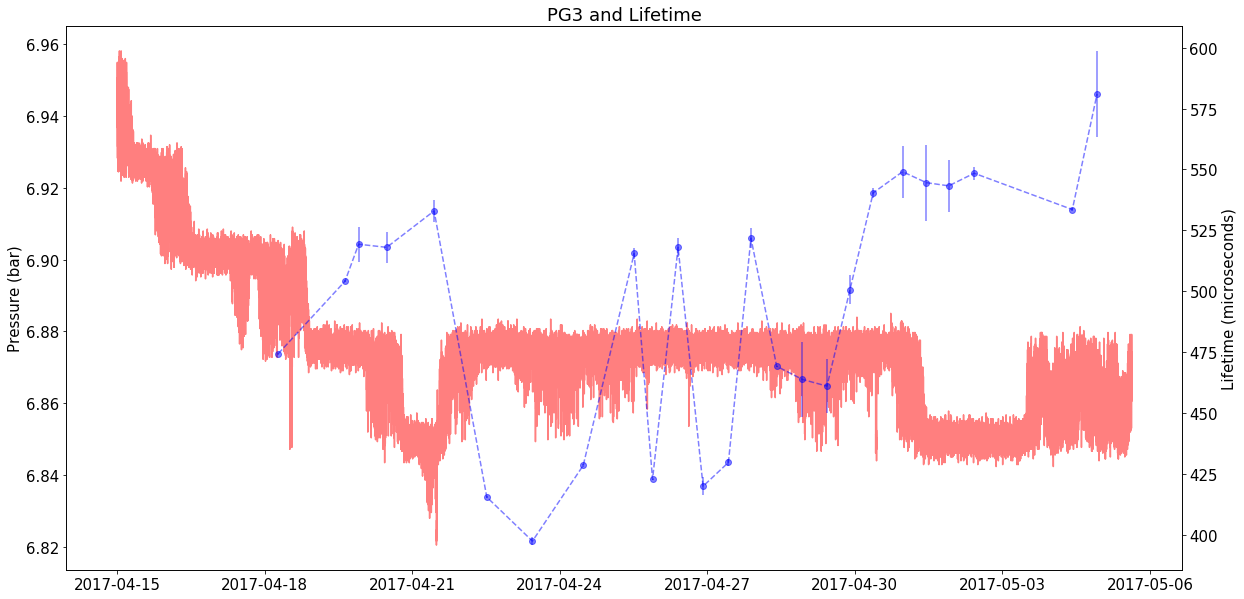

In [69]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(T, [float(v.replace(',','.')) for v in pg3],alpha=.5, c='red')
ax1.set_ylabel('Pressure (bar)')
ax2=ax1.twinx()
ploterr = elambdas
ax2.errorbar(times, lifetimes, yerr=ploterr, linestyle='--', fmt='o', c='blue', alpha=.5)
ax2.set_ylabel('Lifetime (microseconds)')
plt.title('PG3 and Lifetime')
plt.show()

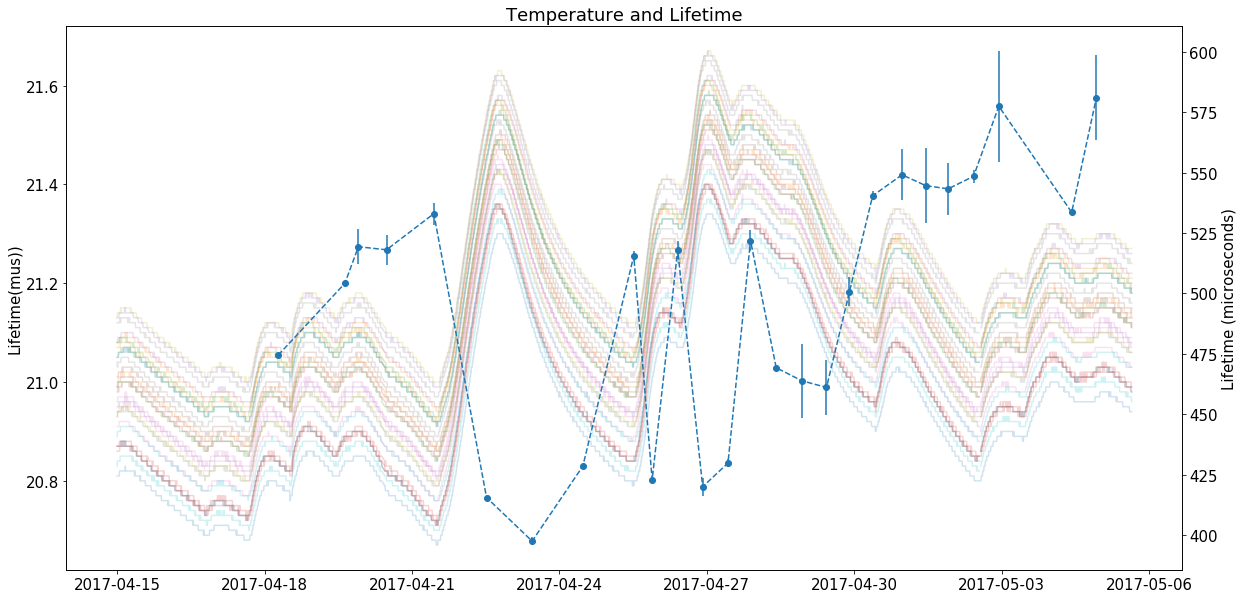

In [11]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(Tt, dbs, alpha=.2)
#ax1.plot(Tt, np.array(dbs).mean(axis=1), c='red', alpha=.5)
ax1.set_ylabel('Lifetime(mus))')
ax2=ax1.twinx()
ploterr = elambdas
ax2.errorbar(times, lifetimes, yerr=ploterr, linestyle='--', fmt='o')
ax2.set_ylabel('Lifetime (microseconds)')
plt.title('Temperature and Lifetime')
plt.show()

In [12]:
runs

[3645,
 3715,
 3724,
 3733,
 3741,
 3753,
 3756,
 3758,
 3762,
 3767,
 3769,
 3772,
 3774,
 3782,
 3784,
 3788,
 3790,
 3793,
 3795,
 3822,
 3824,
 3826,
 3829,
 3855,
 3883,
 3888]

In [13]:
lifetimes

[474.41099311946277,
 504.15251919578071,
 519.30917837870686,
 518.02811413069685,
 532.97159910798757,
 415.51195316787062,
 397.45427486981401,
 428.51794570076862,
 515.50856117526359,
 422.80059055577334,
 518.02083320905024,
 419.97646149139285,
 429.75838777926833,
 521.83297156881144,
 469.21745429222761,
 463.826604058616,
 461.06619446987372,
 500.6616657051581,
 540.39746211228908,
 549.07810091024749,
 544.57593904287273,
 543.26890350017925,
 548.4509769880807,
 577.44503820511011,
 533.54392575703605,
 580.97089224475769]

In [14]:
elambdas

[0.45610521129754389,
 0.39496148002734938,
 7.1924391956263989,
 6.3141707641315312,
 4.5069070673219533,
 0.54717654845191099,
 1.6326697526988669,
 0.58043603501794649,
 2.1244323267837881,
 0.28654390913506583,
 3.822902769037376,
 3.650949171398798,
 1.5991794319982626,
 4.2184333670711194,
 0.2673803059344585,
 15.249539113903822,
 11.22508358475883,
 5.9907961163047405,
 1.9609900515946075,
 10.630602475189789,
 15.572425132253926,
 10.651666662207665,
 2.6543080579975458,
 22.898075395102662,
 0.46222534245673397,
 17.685030116954312]